In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pickle
import numpy as np 

In [2]:
def plot_psid_results(exp):
    with open('results/psid_' + exp + '_acc.pickle', 'rb') as handle:
        bscores, bscores_f = pickle.load(handle)

    #print(bscores_f[0])
    #fig, axs = plt.subplots(2)

    
    print("PSID - mean accuracy :  ",np.mean(bscores[0]))

    #print("PSID - mean accuracy (filtered data) : ", np.mean(bscores_f[0]))
    plt.boxplot(bscores[0])
    plt.show()
    print("PSID - XGB FEATURE IMPORTANCE")
    
    for i in range(len(bscores[1])):
        plt.imshow(bscores[1][i].reshape((7,20)))
        plt.show()

In [3]:
import xgboost as xgb
model = xgb.XGBClassifier(max_depth=5,
                          n_estimators=10,
                          n_jobs=3,
                          eval_metric="logloss",
                          use_label_encoder=False)

In [6]:
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
def auc_scoring(y, y_pred):
    auc_threshold = np.median(y)
    print(auc_threshold)
    ix_true = np.where(y > auc_threshold)[0]
    y_binary = np.zeros(y.shape)
    y_binary[ix_true] = 1
    score = roc_auc_score(y_binary, y_pred - auc_threshold)
    print()
    return score
sys.path.append("..")
from utils.features_utils import block_crossval

In [9]:
def psid_classification(exp,
                       metric = roc_auc_score,
                       freq_buckets = [0,1,2,3,4,5,6],
                       psid_dims = list(range(20)),
                       ):
    metric = roc_auc_score #accuracy_score #auc_scoring

    with open('results/psid_' + exp + '.pickle', 'rb') as handle:
        X, y, blocks_idx = pickle.load(handle)
    nb_obs = X.shape[0]
    #print(X.shape)
    X = X.reshape((nb_obs,7,20))
    #print(X.shape)
    X = X[:, freq_buckets , :] 
    #print(X.shape)
    X = X[:,:,psid_dims]
    #print(X.shape)
    X = X.reshape((nb_obs,-1))
    #print(X.shape)

    crossval_res = block_crossval(X, y, model, blocks_idx, 
                                  metric = metric,
                                  do_plot=True, 
                                  do_feature_imp=True)

    return crossval_res

Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.8472222222222222, 0.7777777777777777, 0.8055555555555556, 0.8611111111111112, 0.8611111111111112] - 83.06%


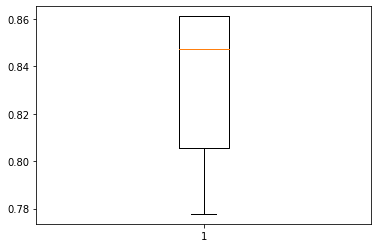

0.8305555555555555
PSID - XGB FEATURE IMPORTANCE


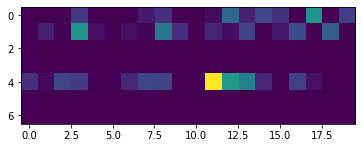

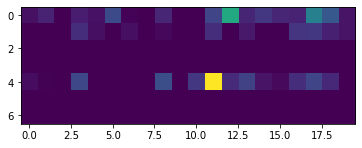

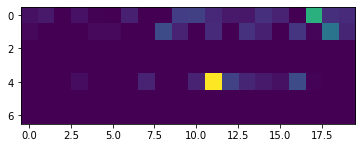

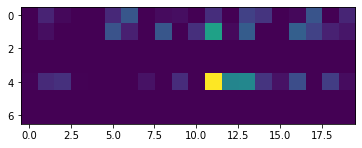

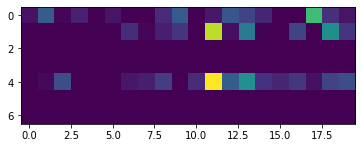

In [16]:
freq_buckets = [0,1,2,3,4,5,6]
psid_dims = list(range(20))
res = psid_classification(exp="2",
                         metric=roc_auc_score,)
print(np.mean(res[0]))
print("PSID - XGB FEATURE IMPORTANCE")

for i in range(len(res[1])):
    plt.imshow(res[1][i].reshape((len(freq_buckets),len(psid_dims))))
    plt.show()